In [1]:
!pip install git+https://github.com/Bots-Avatar/ExplainitAll -q

In [3]:
import os
# os.environ['TEST_MODE_ON_LOW_SPEC_PC'] = 'True'

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os
from sentence_transformers import SentenceTransformer, InputExample, CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from torch.utils.data import DataLoader
from explainitall.embedder_interp.embd_interpret import ModelInterp
from explainitall.QA.extractive_qa_sbert.SVDBert import SVDBertModel
from explainitall.gui.interface import set_verbosity_error
set_verbosity_error()

In [5]:
# Инициализация моделей
SENTENCE_TRANSFORMER_SVD = SentenceTransformer('FractalGPT/SbertSVDDistil' )
SENTENCE_TRANSFORMER_SVD[0].auto_model = SVDBertModel.from_pretrained('FractalGPT/SbertSVDDistil')

CROSS_ENCODER_SVD = CrossEncoder('FractalGPT/SbertSVDDistil', num_labels=1 )
CROSS_ENCODER_SVD.model.bert = SVDBertModel.from_pretrained('FractalGPT/SbertSVDDistil')

In [6]:
def plot_word_contributions(interpreters, sentence, labels):
    '''Интерпретатор, анализ вклада слова в эмбеддинг'''
    words = sentence.split(' ')
    plt.figure(figsize=(len(words) * 1.5, 4))

    for interp, label in zip(interpreters, labels):
        interp_data = interp.seq_interp(sentence)
        plt.bar(interp_data['words'], interp_data['imp'], alpha=0.7, label=label)

    plt.xlabel("Слова", fontsize=15)
    plt.ylabel("Вклад в эмбеддинг", fontsize=15)
    plt.legend(fontsize=13)
    plt.grid(True)

def calculate_action_probabilities(model, task, environment, actions, temperature=1.0):
    context = f'Задача: {task}. Среда: {environment}'
    action_scores = np.array([model.predict([[context, action]])[0] for action in actions])

    action_scores = np.power(action_scores, 1 / temperature)
    action_probabilities = action_scores / action_scores.sum()

    return dict(zip(actions, action_probabilities))

In [7]:
ACTION_SCORES = {
        'объехать': {'d': 0.8, 's': 0},
        'тормозить': {'d': 0.6, 's': 0},
        'повернуть влево': {'d': 0.1, 's': 0},
        'повернуть вправо': {'d': 0.1, 's': 0},
        'ехать прямо': {'d': -0.7, 's': 0}
}


DANGER_OBJECTS  = ['кошка', 'собака', 'человек', 'олень', 'кабан', 'медведь', 'колючая проволока']
SAFE_OBJECTS    = ['асфальт', 'дождь', 'разметка', 'дорожное покрытие', 'листик', 'спичечный коробок', 'рисунок']
TASKS           = ['влево', 'вправо', 'прямо']
TYPES_ENV       = ['s', 'd']

In [8]:
def generate_dataset(action_scores,danger_objects, safe_objects, tasks,types_env, n_samples):
    # Определение влияния действий на оценку

    dataset = []
    for _ in range(n_samples):
        action = random.choice(list(action_scores.keys()))
        task = random.choice(tasks)
        type_env = random.choice(types_env)

        obj = random.choice(danger_objects if type_env == 'd' else safe_objects)
        environment = f'{obj} стоит на дороге'

        # Начальная оценка действия
        score = action_scores[action][type_env]

        # Дополнительная оценка, если задача соответствует действию
        if task in action:
            score += 0.7

        # Нормировка оценки
        score = max(min(score, 1), 0)

        input_text = f'Задача: {task}. Среда: {environment}'
        dataset.append(InputExample(texts=[input_text, action], label=score))

    return dataset

In [9]:
train_samples = generate_dataset(action_scores = ACTION_SCORES,
                                 danger_objects =DANGER_OBJECTS,
                                 safe_objects = SAFE_OBJECTS,
                                 tasks=TASKS,
                                 types_env=TYPES_ENV,
                                 n_samples=15000)




In [10]:
num_epochs = 1

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=64)
evaluator = CECorrelationEvaluator.from_input_examples(train_samples, name='sts-dev')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)
output_path= 'trained_model'

os.makedirs(output_path, exist_ok=True)
CROSS_ENCODER_SVD.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=output_path)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/235 [00:00<?, ?it/s]

In [11]:
# Симуляция RL
calculate_action_probabilities(model = CROSS_ENCODER_SVD,
                               task = 'прямо', environment='Заяц бежит по дороге',
                               actions=list(ACTION_SCORES.keys()), temperature=0.6)

{'объехать': 0.23399602,
 'тормозить': 0.18377523,
 'повернуть влево': 0.22126262,
 'повернуть вправо': 0.19403231,
 'ехать прямо': 0.16693382}

In [12]:
# Меняем Bert на обученный на RL
sbert_rl = SentenceTransformer('FractalGPT/SbertSVDDistil')
sbert_rl[0].auto_model = CROSS_ENCODER_SVD.model.bert

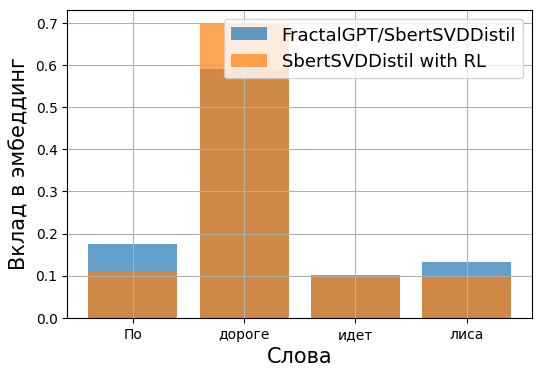

In [13]:
interp_svd = ModelInterp(SENTENCE_TRANSFORMER_SVD)
interp_svd_rl = ModelInterp(sbert_rl)
plot_word_contributions(interpreters = [interp_svd, interp_svd_rl],
                        sentence= 'По дороге идет лиса',
                         labels = ['FractalGPT/SbertSVDDistil', 'SbertSVDDistil with RL'] )